In [24]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go

In [25]:
'''Modify scaling'''
def scale_distances(data, scale_factor=0.8):
    scaled_data = np.copy(data)
    for frame in range(data.shape[0]):
        for i in range(1, data.shape[1]):
            # Calculate the distance between the current joint and the previous joint
            distance = np.linalg.norm(data[frame, i] - data[frame, i-1])
            
            # Scale the distance
            scaled_distance = distance * scale_factor
            
            # Adjust the joint position based on the scaled distance
            direction = (data[frame, i] - data[frame, i-1]) / distance # Get the direction from the previous joint to the current joint
            scaled_data[frame, i] = scaled_data[frame, i-1] + direction * scaled_distance # Update position
    return scaled_data

'''Normalise the joint positions'''
def normalise(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalise = (data - min_val) / (max_val - min_val)
    normalise = normalise * 2 - 1

    return normalise

'''Visualise the joints of the skeleton from HumanML3D dataset'''
# Note ordering (0,1,2) represents the permutaton of the axes, so (0,3,2) displays x, z, y    
def display_skeleton(skeleton, ordering=(0,1,2), joint_num=-1, joints=[], frame=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Set the axis limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Set the axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Get x, y, z coordinates of each joint
    x = skeleton[0, :, ordering[0]] 
    y = skeleton[0, :, ordering[1]]
    z = skeleton[0, :, ordering[2]] 

    if joint_num != -1:
        ax.scatter(x[joint_num], y[joint_num], z[joint_num], c='r', marker='o')

    ax.scatter(x, y, z)

    if len(joints) > 0:
        for joint in joints:
            ax.scatter(x[joint], y[joint], z[joint], c='r', marker='x', s=50)



In [26]:
def csv_to_numpy(dir, single_file=False):
    if not single_file:
        csv_files = os.listdir(dir)
        csv_files = [f for f in csv_files if f.endswith('.csv')]
    else:
        csv_files = [dir]
    
    arrays = []

    for csv in csv_files:
        # Store csv as npy array
        arr = np.genfromtxt(os.path.join(dir, csv), delimiter=',', skip_header=1)

        # Remove time column
        arr = arr[:,1:]

        # Reshape array to frames, joints, 3D positions
        arr = arr.reshape(-1, 28, 3)
        arrays.append(arr)
    
    return arrays

In [27]:
'''Get Emilya and HumanML3D data'''

# Convert a csv file to unmodified NumPy array
csv = '/Users/joe/Documents/project/experiment/Convert-EMILYA/output/csv/000001.csv' # This will need to be changed to the location of the csv file
arr = np.genfromtxt(csv, delimiter=',', skip_header=1)
arr = arr[:,1:]
arr = arr.reshape(-1, 28, 3)

# Scale then normalise
arr = scale_distances(arr, 6.5)
arr = normalise(arr)
print(arr.shape)

# Load a HumanML3D skeleton for comparison
humanML3D = np.load("/Users/joe/Documents/project/experiment/HumanML3D/HumanML3D/new_joints/000000.npy") # This will need to be changed the directory of HumanML3D
print(humanML3D.shape)

(410, 28, 3)
(116, 22, 3)


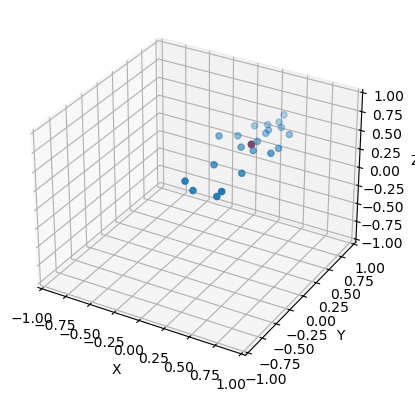

In [28]:
'''Display HumanML3D skeleton'''
display_skeleton(humanML3D, (0, 1, 2), 0) # note the change of axes ordering

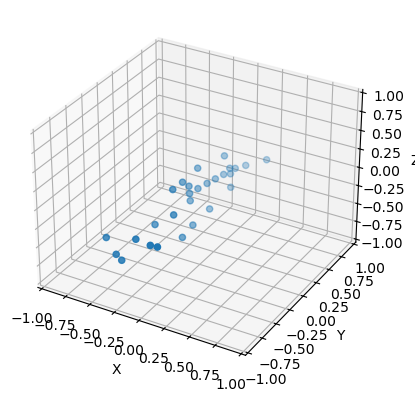

In [29]:
'''Display EMILYA skeleton'''
display_skeleton(arr) # note the change of axes ordering

(116, 22, 3) (410, 22, 3)


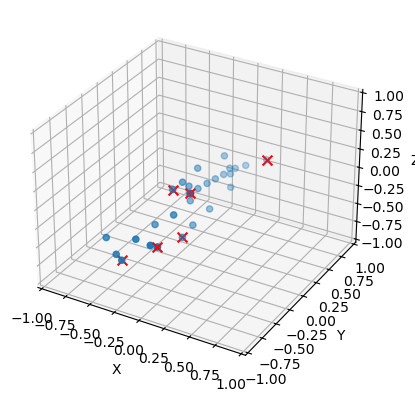

In [30]:
'''Display joints to be deleted'''

# this code only works for a csv converted to a npy file
to_delete = [0, 5, 10, 19, 24, 27]
display_skeleton(arr, ordering=(0, 1, 2), joint_num=0, joints=to_delete, frame=len(arr)-1)

# Remove joints to fit data
emilya = np.delete(arr, to_delete, axis=1)
print(humanML3D.shape, emilya.shape)
# Will have some retargeting error hopefully doesnt affect emotion - cannot avoid this 


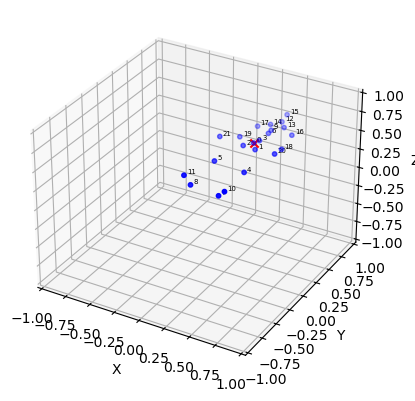

In [31]:
'''Number the skeleton joints for remapping'''
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') # Add 3D axis   

# Set the axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

frame = len(humanML3D) - 1
x = humanML3D[frame, :, 0] 
y = humanML3D[frame, :, 1]
z = humanML3D[frame, :, 2]

ax.scatter(x, y, z, c='b', marker='o', s=10) 


# Add joint numbers
for joint in range(len(x)):
    ax.text(x[joint] + 0.02, y[joint] + 0.02, z[joint] + 0.02, 
            f'{joint}',  # The joint number
            fontsize=5)  # Slight offset to avoid overlap

# It's quite hard to see which joint is which near the middle so we can highlight the joint here
joint_num = 0
ax.scatter(x[joint_num], y[joint_num], z[joint_num], c='r', marker='x', s=35)

In [32]:
#Remap the indicies to the HumanML3D skeleton
'''
def remap():
    remap = {
            8: 0, 0: 1, 4: 2, 9: 3, 1: 4, 5: 5, 10: 6, 2: 7,
            6: 8, 11: 9, 3: 10, 7: 11, 20: 12, 12: 13, 16: 14,
            21: 15, 13: 16, 17: 17, 14: 18, 18: 19, 15: 20, 19: 21
        }

    remapped = np.zeros_like(emilya)

    for old, new in remap.items():
        remapped[:, new] = emilya[:, old]

    return remapped
emilya = remap()
'''

'\ndef remap():\n    remap = {\n            8: 0, 0: 1, 4: 2, 9: 3, 1: 4, 5: 5, 10: 6, 2: 7,\n            6: 8, 11: 9, 3: 10, 7: 11, 20: 12, 12: 13, 16: 14,\n            21: 15, 13: 16, 17: 17, 14: 18, 18: 19, 15: 20, 19: 21\n        }\n\n    remapped = np.zeros_like(emilya)\n\n    for old, new in remap.items():\n        remapped[:, new] = emilya[:, old]\n\n    return remapped\nemilya = remap()\n'

In [33]:
import plotly.graph_objects as go

'''Latrr I just used code from plotly to animate the skeleton after taking inspiration from MMM's visualisation'''

def animate_3d(arr):
    num_frames = arr.shape[0]

    frames = []
    for i in range(num_frames):
        frame_data = arr[i]
        scatter = go.Scatter3d(
            x=frame_data[:, 0],
            y=frame_data[:, 1],
            z=frame_data[:, 2],
            mode='markers',
            marker=dict(size=5, color='red')
        )
        frames.append(go.Frame(data=[scatter], name=f"frame{i}"))

    initial_data = frames[0].data[0]

    # Range of axis
    x_range = [arr[:, :, 0].min(), arr[:, :, 0].max()]
    y_range = [arr[:, :, 1].min(), arr[:, :, 1].max()]
    z_range = [arr[:, :, 2].min(), arr[:, :, 2].max()]

    fig = go.Figure(
        data=[initial_data],
        layout=go.Layout(
            title="Animated Motion Data",
            scene=dict(
                xaxis=dict(title='X', range=x_range),
                yaxis=dict(title='Y', range=y_range),
                zaxis=dict(title='Z', range=z_range)
            ),
            updatemenus=[
                {
                    "type": "buttons",
                    "buttons": [
                        {
                            "label": "Play",
                            "method": "animate",
                            "args": [None, {
                                "frame": {"duration": 100, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0}
                            }]
                        },
                        {
                            "label": "Pause",
                            "method": "animate",
                            "args": [[None], {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}
                            }]
                        }
                    ]
                }
            ]
        ),
        frames=frames
    )

    fig.show()

motion = humanML3D
animate_3d(motion)

In [34]:
'''Code to create skeletons seen in figures'''
def display_skeleton_interactive(data, frame=0):
    frame = data[frame]

    x = frame[:, 0]
    y = frame[:, 1]
    z = frame[:, 2]


    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(size=3, color='blue')
    )])

    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title='',
                showticklabels=False,
                backgroundcolor='rgba(0,0,0,0)',
                gridcolor='rgba(0,0,0,0)'
            ),
            yaxis=dict(
                title='',
                showticklabels=True,
                backgroundcolor='rgba(0,0,0,0)',
                gridcolor='rgba(0,0,0,0)'
            ),
            zaxis=dict(
                title='',
                showticklabels=False,
                backgroundcolor='rgba(0,0,0,0)',
                gridcolor='rgba(0,0,0,0)'
            ),
            bgcolor='rgba(0,0,0,0)'  # Transparent 3D scene background
        ),
        paper_bgcolor='rgba(0,0,0,0)'   # Transparent outer figure background
    )
    
    fig.show()

display_skeleton_interactive(humanML3D, frame=0)